In [2]:
import keras
import scipy.io as sio
import os
from keras.applications import imagenet_utils
from keras.preprocessing.image import img_to_array
from keras.preprocessing.image import load_img
import numpy as np
import h5py
from keras.utils.np_utils import to_categorical
import numpy as np
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential
from keras.layers import Dropout, Flatten, Dense, Conv2D, MaxPooling2D
from keras import applications
# Plot images
from keras.datasets import mnist
from matplotlib import pyplot as plt

Using TensorFlow backend.


In [3]:
from keras.datasets import fashion_mnist

In [4]:
(X_train, y_train), (X_test, y_test) = fashion_mnist.load_data()
# plot 4 images as gray scale

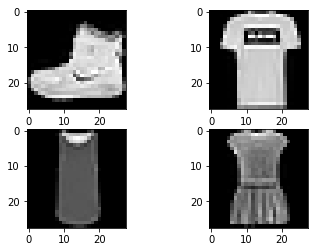

In [5]:
#visualizing data
plt.subplot(221)
plt.imshow(X_train[0], cmap=plt.get_cmap('gray'))
plt.subplot(222)
plt.imshow(X_train[1], cmap=plt.get_cmap('gray'))
plt.subplot(223)
plt.imshow(X_train[2], cmap=plt.get_cmap('gray'))
plt.subplot(224)
plt.imshow(X_train[3], cmap=plt.get_cmap('gray'))
# show the plot
plt.show()

In [6]:
img_rows, img_cols = 28, 28
x_train = X_train.reshape(X_train.shape[0], img_rows, img_cols, 1)
x_test = X_test.reshape(X_test.shape[0], img_rows, img_cols, 1)
input_shape = (img_rows, img_cols, 1)

In [7]:
x_train = x_train.astype('float32')
x_test = x_test.astype('float32')
x_train /= 255
x_test /= 255
print('x_train shape:', x_train.shape)
print(x_train.shape[0], 'train samples')
print(x_test.shape[0], 'test samples')

('x_train shape:', (60000, 28, 28, 1))
(60000, 'train samples')
(10000, 'test samples')


In [9]:
# convert class vectors to binary class matrices
num_classes = len(set(y_train))
print num_classes
y_train = keras.utils.to_categorical(y_train, num_classes)
y_test = keras.utils.to_categorical(y_test, num_classes)

10


### Defining a simple model here

In [10]:
model = Sequential()
model.add(Conv2D(32, kernel_size=(3, 3),
                 activation='relu',
                 input_shape=input_shape))
model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))
model.add(Flatten())
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(num_classes, activation='softmax'))

model.compile(loss=keras.losses.categorical_crossentropy,
              optimizer=keras.optimizers.Adadelta(),
              metrics=['accuracy'])

### Defining a callback that records the activation output for the fully connected layers

In [15]:
print model.summary()
import keras.backend as K
class ActivationOutputHistory(keras.callbacks.Callback):
  
    def on_train_begin(self, logs={}):
        self.losses = []
        self.activation4 = []
        self.activation5 = []
    
    

    def on_epoch_end(self, epoch, logs={}):
        print ("in activation output callback ")
        get_fourth_layer_output= K.function([self.model.layers[0].input, K.learning_phase()],
                                  [self.model.layers[4].output])
        get_fifth_layer_output= K.function([self.model.layers[0].input, K.learning_phase()],
                                  [self.model.layers[5].output])
        
        self.losses.append(logs.get('loss'))
        #layer_output = get_3rd_layer_output([X, 1])[0]
        print ("getting output for 4th layer ")
        self.activation4.append(get_fourth_layer_output([x_train[:500], 1])[0])
        self.activation5.append(get_fifth_layer_output([x_train[:500], 1])[0])
         print ("getting output for 5th layer ")
        self.activation4[-1] += get_fourth_layer_output([x_train[500:], 1])[0]
        self.activation5[-1] += get_fifth_layer_output([x_train[500:], 1])[0]

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_3 (Conv2D)            (None, 26, 26, 32)        320       
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 24, 24, 64)        18496     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 12, 12, 64)        0         
_________________________________________________________________
dropout_3 (Dropout)          (None, 12, 12, 64)        0         
_________________________________________________________________
flatten_2 (Flatten)          (None, 9216)              0         
_________________________________________________________________
dense_2 (Dense)              (None, 128)               1179776   
_________________________________________________________________
dropout_4 (Dropout)          (None, 128)               0         
__________

In [16]:
batch_size = 128
num_classes = 10
epochs = 2
activation_history = ActivationOutputHistory()

ret = model.fit(x_train[:1000], y_train[:1000],
          batch_size=batch_size,
          epochs=epochs,
          verbose=1,
          validation_data=(x_test[:200], y_test[:200]), callbacks = [activation_history])
         
# #print ret.history()

# ret = model.fit(x_train, y_train,
#           batch_size=batch_size,
#           epochs=epochs,
#           verbose=1,
#           validation_data=(x_test, y_test), callbacks = [activation_history])
         
#print ret.history()

Train on 1000 samples, validate on 200 samples
Epoch 1/2
 896/1000 [=========================>....] - ETA: 0s - loss: 1.5916 - acc: 0.4989

ValueError: operands could not be broadcast together with shapes (500,9216) (59500,9216) (500,9216) 

In [13]:
score = model.evaluate(x_test, y_test, verbose=1)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

10000/10000 [==============================] - 11s 1ms/step
('Test loss:', 1.6634386386871338)
('Test accuracy:', 0.49859999999999999)


In [14]:
print ret.history
print len(activation_history.activation4)
print activation_history.activation4[0].shape
print len(activation_history.activation5)
print activation_history.activation5[0].shape

{'acc': [0.21199999713897705, 0.37600000143051149], 'loss': [2.206793514251709, 1.9345671072006225], 'val_acc': [0.46000000834465027, 0.5], 'val_loss': [1.9755597114562988, 1.6749768257141113]}
2
(500, 9216)
2
(500, 128)


In [ ]:
print ("this function will take the output of hidden layers and bin them into 30 bins (by default) from -1 to 1 and return the means and probability of each bin ")
def bin_hidden_layers(T, num_bins = 30, beg = -1, end =1 ):
    import numpy as np
    data = np.array(T)
    bins = numpy.linspace(beg, end, num_bins)
    digitized = numpy.digitize(data, bins)
    print (digitized)
    bin_means = [data[digitized == i].mean() for i in range(1, len(bins) +1)]
    print (bin_means)
    
    binned_data = digitized -1

    from collections import Counter
    counter = Counter(binned_data)

    binned_mean = []
    binned_probability = []
    for class1 in counter :
        prob = counter[class1]/ len(binned_data)
        bin_mean = bin_means[class1]
#         print (class1 )
#         print (prob)
#         print (bin_mean)
        binned_mean.append(bin_mean)
        binned_probability.append(prob)

    
    return (binned_mean , binned_probability)

In [ ]:
print ("test function for binning ")
import numpy 
T  = [-1, -0.7, -0.4, -0.3, -0.2,-1, -0.7, -0.4, -0.3, -0.2,-1, -0.7, -0.4, 
      -0.3, -0.2,-1, -0.7, -0.4, -0.3, -0.2, 1, 0, 0.4, 0.3, 0.2, 0.1, 0.5, 0.55, 0.56 ]
T = numpy.array(T)
print (T)
binned_mean , binned_probability = bin_hidden_layers(T, num_bins=4)
print (binned_mean)
print (binned_probability)

- We need to find :
- I(X;T), I(T;Y)
- I(X;T) = H(X) - H(X|T)
- I(T;Y) = H(T) - H(T|Y)

- H(X) =  - Sum(p(x) log p(x))

- We need P(X), P(T), P(X|T), P(T|Y)

- Calculate P(x) -> we can take each datapoint to be equally distributed , so the 1/num_of_samples
- Calculate P(y) -> we can calculate by just taking distribution of sample labels using Counter 

- get value of t for every neuron , bin this data into (30?) intervals , get a distribution of P(T) ( also P(T,x ) = ?))
- P(Ti; Y ) = Sum( P(x, Y )P(Ti|x) )


- Train over 100 epochs
- Get value for hidden layers for each data point

- We have distributions of X and Y , need the distribution of T.  We can do this by generating the values of T after every epoch (possible with tf, see if Keras has too)  
- scikit learn method : http://scikit-learn.org/stable/modules/clustering.html#mutual-info-score 
-  We have to get T , look at call back in Keras 

-  Done Bin T as given in paper into 30? (maybe 40 for ease of calculation)  and get a distribution of T after every epoch 

- So for every X  [ where X is a  28 *28 *3 vector ] we will have multiple Ts and one Y  

- Solution 1
- get distributions for T, X and Y and calculate mutual info score using sklearn.mutual_info_score

